In [1]:
import pandas as pd
import numpy as np
import nltk, re
nltk.download('stopwords') # load english stopwords
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix,vstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from functools import partial



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load training dataset and define independant and dependant variable

In [2]:
dataset = pd.read_csv('training_data.csv')
print(dataset.shape)

X=dataset['titles'].values
Y=dataset['labels'].values
print(type(X))

(575907, 2)
<class 'numpy.ndarray'>


#### Pre-processing for stopwords, whitespaces, digits which corresponds to weight of the commodity in the titles.

In [3]:
def text_preprocess(text,join_with):
    """
        text: a string
        
        return: modified initial string
    """
    special_symbols = re.compile('[/(){}\[\]\|@,;]')
    special_characters = re.compile('[^0-9a-z #+_]')
    stop_words = list((stopwords.words('english')))
    digits = re.compile('[0-9]+')
    text = text.lower() 
    text = re.sub(special_symbols," ",text,)
    text = re.sub(special_characters,"",text)
    text = re.sub(r'\s+'," ",text)
    text = re.sub(digits,"", text)

    text = f'{join_with}'.join([i for i in text.split() if i not in stop_words])
    
    return text

In [4]:
X = [text_preprocess(x,' ') for x in X]
Y = [text_preprocess(x,',') for x in Y]

#### Create dictionary of all train corpus and thier frequencies

Counter({'beverages': 177706, 'snacks': 172679, 'branded': 101891, 'grocery': 101891, 'sweets': 76286, 'confectionery': 73089, 'dairy': 59141, 'breakfast': 59049, 'cereals': 59049, 'food': 45967, 'instant': 41860, 'care': 39641, 'personal': 19111, 'medicines': 16454, 'healthcare': 15739, 'wellness': 15739, 'drugs': 15739, 'home': 13433, 'fruits': 12455, 'staples': 12329, 'vegetables': 11061, 'cosmetics': 9158, 'makeup': 9158, 'repellent': 7074, 'insect': 7068, 'pest': 7067, 'repellents': 7067, 'oil': 5788, 'edible': 5705, 'frozen': 5005, 'bakery': 4832, 'hand': 4184, 'chocolate': 3964, 'hair': 3786, 'baby': 3413, 'spices': 2722, 'masala': 2715, 'eggs': 2464, 'bars': 2376, 'gel': 2227, 'sanitizer': 2092, 'seafood': 2038, 'water': 1983, 'sauces': 1935, 'accessories': 1841, 'products': 1837, 'pickles': 1719, 'biscuits': 1637, 'powder': 1603, 'nuts': 1505, 'dried': 1482, 'readytocook': 1400, 'cookies': 1378, 'deodorants': 1269, 'antiprespirants': 1269, 'ghee': 1268, 'coffee': 1221, 'soaps'

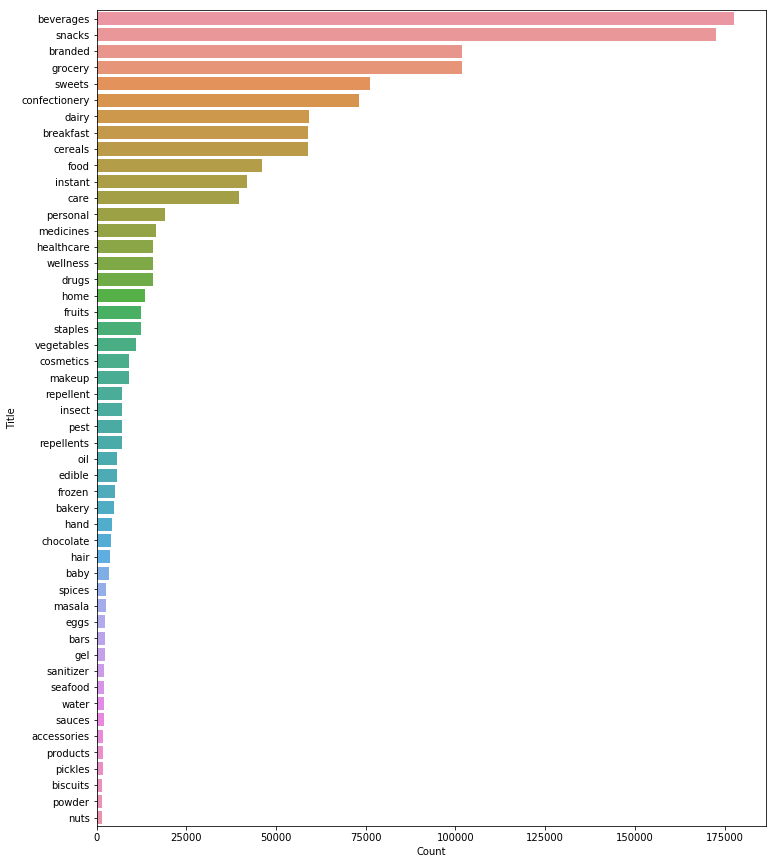

In [5]:
tags_counts = Counter(chain.from_iterable([i.split(",") for i in Y]))
print(tags_counts)
all_titles = nltk.FreqDist(tags_counts) 
all_titles_df = pd.DataFrame({'Title': list(all_titles.keys()), 
                              'Count': list(all_titles.values())})

g = all_titles_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Title") 
plt.show()
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X]))

#### Text to vector transformation

In [6]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
ALL_WORDS = WORDS_TO_INDEX.keys()
print(ALL_WORDS)
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    keys= [words_to_index[i] for i in text.split(" ") if i in words_to_index.keys()]
    result_vector[keys]=1
    return result_vector

dict_keys(['g', 'tea', 'ml', 'organic', 'chocolate', 'n', 'gm', 'healthy', 'alternatives', 'kg', 'milk', 'culture', 'get', 'food', 'gms', 'natures', 'best', 'conscious', 'w', 'green', 'powder', 'loose', 'l', 'dark', 'juice', 'fruit', 'lexclusif', 'bar', 'rice', 'masala', 'coffee', 'oil', 'mix', 'roasted', 'honey', 'instant', 'mantra', 'cream', 'noodles', 'whole', 'black', 'tb', 'seeds', 'pack', 'devi', 'almond', 'pcs', 'chicken', 'pouch', 'cookies', 'dal', 'garden', 'butter', 'flour', 'chips', 'sugar', 'red', 'flavour', 'lemon', 'india', 'nuts', 'white', 'drink', 'orange', 'beans', 'strawberry', 'free', 'original', 'muesli', 'crunchy', 'pure', 'mango', 'cheese', 'oats', 'nature', 'natural', 'koka', 'peanut', 'olive', 'wheat', 'cadbury', 'u', 'kelloggs', 'syrup', 'snack', 'pepper', 'tong', 'classic', 'apple', 'lindt', 'vanilla', 'desi', 'fresh', 'almonds', 'salt', 'potato', 'real', 'gold', 'blue', 'protein', 'tomato', 'choco', 'belgian', 'extra', 'ginger', 'bb', 'american', 'hazelnut', 

#### Transform each element of labels to dictionary and than pass it to multilabelbinarizer

In [7]:
Y = [set(i.split(',')) for i in Y]
mlb= MultiLabelBinarizer()
mlb.fit(Y)

# transform target variable
y = mlb.transform(Y)
y.shape

(575907, 385)

####  Split the dataset into train and test using 70-30 split ratio

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [9]:
mlb.classes_

array(['absorber', 'accessories', 'adult', 'aerated', 'agents',
       'agricultural', 'aid', 'air', 'almonds', 'aluminium',
       'antiprespirants', 'antiseptics', 'appalam', 'appliances',
       'artificial', 'asterigents', 'atta', 'aval', 'avalakki',
       'ayurvedic', 'baby', 'badam', 'bags', 'bajra', 'bakery', 'baking',
       'balls', 'balm', 'bar', 'barley', 'bars', 'base', 'basmati',
       'bath', 'bathing', 'bathroom', 'batteries', 'battery', 'beaten',
       'bengal', 'besan', 'beverages', 'bhaji', 'biscuits', 'blades',
       'bleach', 'blended', 'body', 'boiled', 'bottle', 'bran', 'branded',
       'bread', 'breakfast', 'broom', 'brush', 'brushes', 'bun', 'butter',
       'cake', 'camphor', 'candles', 'canned', 'canola', 'car', 'care',
       'cashewnuts', 'cashews', 'casserole', 'cat', 'ceiling', 'cereals',
       'chana', 'channa', 'cheese', 'chewing', 'chicken', 'chikki',
       'chips', 'chocolate', 'cleaner', 'cleaners', 'cleaning',
       'cleanser', 'cleansing', '

#### Bag of words implementation

In [10]:
x_train_mybag = vstack([csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in x_train])
x_test_mybag = vstack([csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in x_test])
print('x_train shape ', x_train_mybag.shape)
print('x_test shape ', x_test_mybag.shape)

x_train shape  (403134, 5000)
x_test shape  (172773, 5000)


#### Naive bayes model to build classifier

In [26]:
"""
NOTE: Hyper-parameter tuniing  to come up with value for c. this is than used in train_classifier
hypers = np.arange(0.1, 1.0, 1.1)
res = []

for h in hypers:
    temp_model = train_classifier(x_train_mybag, y_train, C=h)
    temp_pred = f1_score(y_test, temp_model.predict(X_test_mybag), average='weighted')
    res.append(temp_pred)
"""
def train_classifier(x_train, y_train,C=1.0):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    print("start")
    model = MultinomialNB(alpha=1.0)
    model = OneVsRestClassifier(model)
    model.fit(x_train, y_train)
    

    return model
print("model done")
# Linear NLP model using bag of words approach
%time classifier_mybag = train_classifier(x_train_mybag, y_train, C=1.0)

model done
start
Wall time: 49.9 s


#### Prediction on hold out dataset

In [27]:
y_test_predicted_labels_mybag = classifier_mybag.predict(x_test_mybag)

In [28]:
y_test_predicted_labels_mybag[3]
mlb.inverse_transform(y_test_predicted_labels_mybag)[3]
y_test_predicted_labels_mybag_p = classifier_mybag.predict_proba(x_test_mybag)

In [29]:
probability_score=y_test_predicted_labels_mybag_p.max(axis=1)

In [31]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_mybag)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        x_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	orange fruit juice mantra organic l
True labels:	beverages,snacks
Predicted labels:	beverages,snacks


Title:	aloevera litchi juice unati ml
True labels:	beverages,snacks
Predicted labels:	beverages,snacks,water


Title:	ct cinnoman ice breaker g
True labels:	confectionery,sweets
Predicted labels:	confectionery,sweets




In [32]:
f1_score(y_test, y_test_predicted_labels_mybag, average="micro")

0.7241587807458207

In [33]:

def print_evaluation_scores(y_val, predicted):
    f1_score_macro = partial(f1_score,average="macro")
    print(f1_score_macro)
    f1_score_micro = partial(f1_score,average="micro")
    f1_score_weighted = partial(f1_score,average="weighted")
    
    average_precision_score_macro = partial(average_precision_score,average="macro")
    average_precision_score_micro = partial(average_precision_score,average="micro")
    average_precision_score_weighted = partial(average_precision_score,average="weighted")
    
    scores = [accuracy_score,f1_score_macro,f1_score_micro,f1_score_weighted,average_precision_score_macro,
             average_precision_score_micro,average_precision_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Bag-of-words')
print(y_test.shape)
print(y_test_predicted_labels_mybag.shape)
print_evaluation_scores(y_test, y_test_predicted_labels_mybag)
# print('Tfidf')
# print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Bag-of-words
(172773, 385)
(172773, 385)
functools.partial(<function f1_score at 0x000001AC03319598>, average='macro')
<function accuracy_score at 0x000001AC03319268> 0.6776116638595151
functools.partial(<function f1_score at 0x000001AC03319598>, average='macro') 0.09332496762194459
functools.partial(<function f1_score at 0x000001AC03319598>, average='micro') 0.7241587807458207
functools.partial(<function f1_score at 0x000001AC03319598>, average='weighted') 0.8240830258571248
functools.partial(<function average_precision_score at 0x000001AC03309AE8>, average='macro') nan
functools.partial(<function average_precision_score at 0x000001AC03309AE8>, average='micro') 0.5487588199123377
functools.partial(<function average_precision_score at 0x000001AC03309AE8>, average='weighted') nan


#### Train classifier on entire training dataset

In [34]:
x_mybag = vstack([csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X])


In [35]:
classifier = train_classifier(x_mybag, y, C=1.0)

start


In [36]:
dataset_predicted_labels_mybag = classifier.predict(x_mybag)
y_dataset_pred_inversed = mlb.inverse_transform(dataset_predicted_labels_mybag)
print(y_dataset_pred_inversed[1])
# mlb.inverse_transform(y_test_predicted_labels_mybag)[3]
dataset_predicted_labels_mybag_p = classifier.predict_proba(x_mybag)
probability_score=dataset_predicted_labels_mybag_p.max(axis=1)



('beverages', 'snacks')


#### Store entire dataset predictions along with probability scores

In [40]:
Dataset_full_train=dataset
Dataset_full_train['Predicted_Labels']=y_dataset_pred_inversed
Dataset_full_train['Predicted_Probability']=probability_score
#print(Dataset_full_train.head)

<bound method NDFrame.head of                                                    titles  \
0       britannia nutri choice - hi fibre digestive bi...   
1       soya nuts - roasted lime snack - healthy alter...   
2             whole mung organic - conscious food - 500 g   
3       good knight activ + liquid refill - lavender, ...   
4       holy basil (tulsi) honey - healthy alternative...   
5       instant espresso freeze dried coffee - grandos...   
6       original dark chocolate goldenberry - pacari -...   
7                   dove hair fall rescue shampoo, 340 ml   
8                 anoushka gourmet moong dal halwa 285gms   
9                                  tea - red label - 1 kg   
10      finest american almond - healthy alternatives ...   
11                                     sweet corn - 250 g   
12                          choice fryms papad white 150g   
13      espresso caffe in grani coffee beans - illy - ...   
14      milk chocolate egg - monster collection - zain.

In [44]:
f1_score(y,dataset_predicted_labels_mybag, average="micro")

0.7303413567214142

#### Predict on the evaluation dataset

In [45]:
validation = pd.read_csv('evaluate_data.csv')
print(validation.shape)

x_val=validation['titles'].values
print(type(x_val))

(143977, 1)
<class 'numpy.ndarray'>


#### Preprocess this dataset by carrying out same pre-process functions used on training dataset

In [46]:
# X_val = [text_preprocess(x_val,' ') for x in x_val]
X_val = [text_preprocess(x,' ') for x in x_val]

In [47]:
x_val_mybag = vstack([csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])

In [48]:
y_val_predicted_labels_mybag = classifier.predict(x_val_mybag)

In [49]:
y_val_predicted_labels_mybag[3]
mlb.inverse_transform(y_val_predicted_labels_mybag)[3]

('confectionery', 'sweets')

In [52]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
#print(y_val_pred_inversed)
for i in range(3):
    print('Title:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_pred_inversed[i])
    ))
    

Title:	tomato puree smart cook g
Predicted labels:	branded,grocery


Title:	nutrichoice hi fiber digestive britannia g
Predicted labels:	beverages,snacks


Title:	amul mithai mate gms
Predicted labels:	bakery,bread,chocolate,milk




In [54]:
y_val_predicted_labels_mybag_p = classifier.predict_proba(x_val_mybag)
probability_score_test=y_val_predicted_labels_mybag_p.max(axis=1)

#### Save evaluation dataset along with its predictions and probability scores

In [55]:
evaluation_dataset_scoring=validation
evaluation_dataset_scoring['Predicted_Labels']=y_val_pred_inversed
evaluation_dataset_scoring['Predicted_Probability']=probability_score_test

In [56]:
print(evaluation_dataset_scoring.head)

<bound method NDFrame.head of                                                    titles  \
0                       tomato puree - smart cook - 200 g   
1       nutrichoice hi fiber digestive - britannia - 2...   
2                                 amul mithai mate 200gms   
3       dark chocolate bar w/ caramelized orange rinds...   
4                           garam masala - everest - 50 g   
5              salted cocktail nuts - tong garden - 150 g   
6              seville orange marmalade - mackays - 340 g   
7                                   mamy poko pants s 42s   
8              strawberry preserves - bonne maman - 370 g   
9       cup a soup w/ croutons tomato & vegetable - ba...   
10         triple grains - gluten free - zero - g - 500 g   
11             bb royal organic - coriander powder, 200 g   
12      body buddy protein ready to eat chocolate oran...   
13             instant classical coffee - grandos - 100 g   
14             top deck milk chococlate - cadbury - 220